<a href="https://colab.research.google.com/github/Changho0514/web1/blob/main/RNN%26N_BEATS(%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주식 시장 예측해보기

resource: https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm


#### 이번 실습에서는 주가 데이터를 예측하는 일을 해볼 것 입니다. 
#### RNN, LSTM, GRU, N-BEATS 모델을 통해 미래의 주가를 예측해봅시다.

# 1. Pandas 를 이용한 데이터 전처리 및 matplotlib, seaborn 을 이용한 데이터 시각화

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
!pip install yfinance
import yfinance as yf
from datetime import datetime

# Apple, Google, Microsoft, Amazon 데이터를 수집해봅시다
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 10, end.month, end.day) # 오늘부터 이전 10년간의 데이터를 모아봅시다.

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end) # yfinance 라이브러리는 주식 데이터를 자동으로 다운로드 받게 해줍니다.

     |████████████████████████████████| 63 kB 957 kB/s 
     |████████████████████████████████| 6.4 MB 8.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*******

Let's go ahead and play aorund with the AAPL DataFrame to get a feel for the data

In [3]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)

데이터는 6가지의 feature로 구성되어 있습니다.
1. Open(시작가)
2. High(최고가)
3. Low(최저가)
4. Close(종가)
5. Adj Close(조정된 종가)
6. Volume(거래량)

In [4]:
df

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2012-01-12,15.081429,15.103571,14.955357,15.049643,12.903039,212587200,APPLE
2012-01-13,14.989286,15.016071,14.952143,14.993214,12.854657,226021600,APPLE
2012-01-17,15.150000,15.213929,15.105714,15.167857,13.004394,242897200,APPLE
2012-01-18,15.248571,15.338214,15.225000,15.325357,13.139429,276791200,APPLE
2012-01-19,15.362500,15.406071,15.232500,15.276786,13.097784,261738400,APPLE
...,...,...,...,...,...,...,...
2022-01-05,3337.659912,3342.530029,3287.139893,3287.139893,3287.139893,3215100,AMAZON
2022-01-06,3269.010010,3296.000000,3238.739990,3265.080078,3265.080078,2597900,AMAZON
2022-01-07,3276.780029,3304.870117,3240.620117,3251.080078,3251.080078,2329300,AMAZON


In [5]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,49.462477,49.981625,48.956846,49.490676,47.737024,2.145457e+08
std,39.220763,39.693572,38.772853,39.259075,39.903133,1.759101e+08
min,13.856071,14.271429,13.753571,13.947500,12.134603,4.100000e+07
25%,23.732500,23.934999,23.472500,23.707500,21.353045,1.027696e+08
50%,32.517502,32.735001,32.307499,32.529999,29.691391,1.506940e+08
75%,54.447498,55.112499,53.782501,54.415001,52.694378,2.644760e+08
max,182.630005,182.940002,179.119995,182.009995,182.009995,1.506120e+09


In [6]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-01-12 to 2022-01-11
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2517 non-null   float64
 1   High          2517 non-null   float64
 2   Low           2517 non-null   float64
 3   Close         2517 non-null   float64
 4   Adj Close     2517 non-null   float64
 5   Volume        2517 non-null   int64  
 6   company_name  2517 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 157.3+ KB


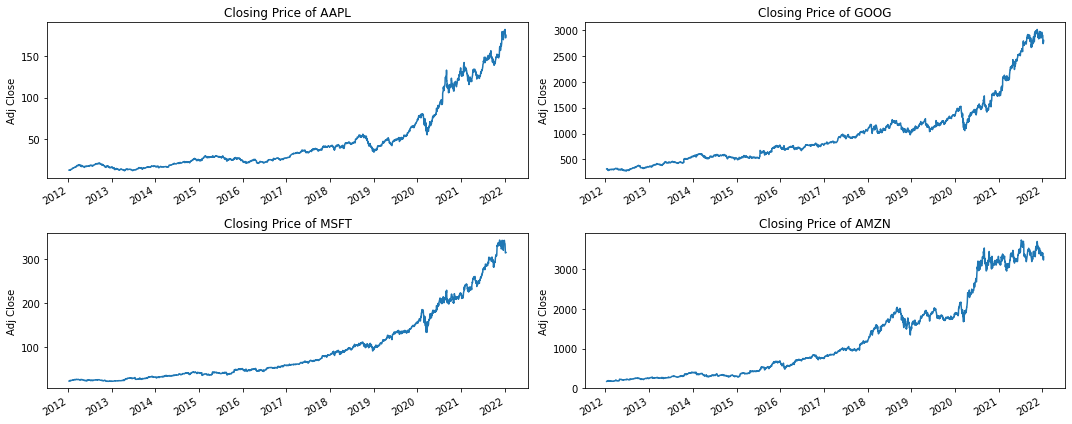

In [7]:
# 과거의 종가 데이터를 한번 확인해봅시다.


plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

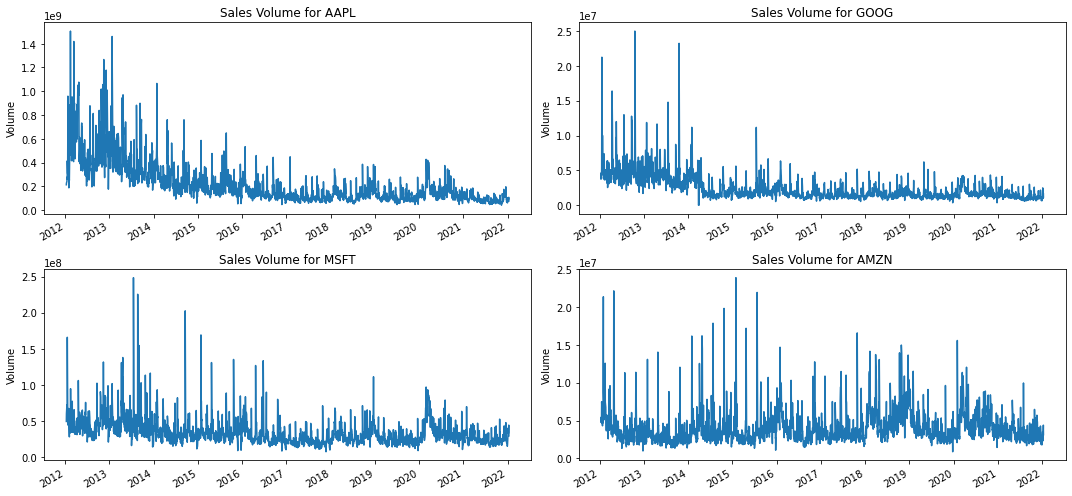

In [8]:
# 과거의 거래량을 확인해봅시다.
plt.figure(figsize=(15, 7))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

company_name
AMAZON       [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
APPLE        [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
GOOGLE       [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
MICROSOFT    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

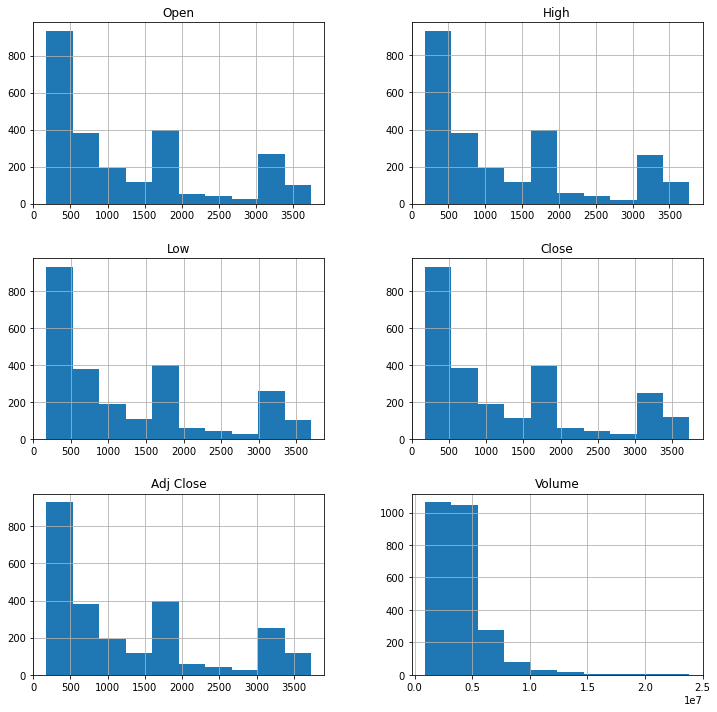

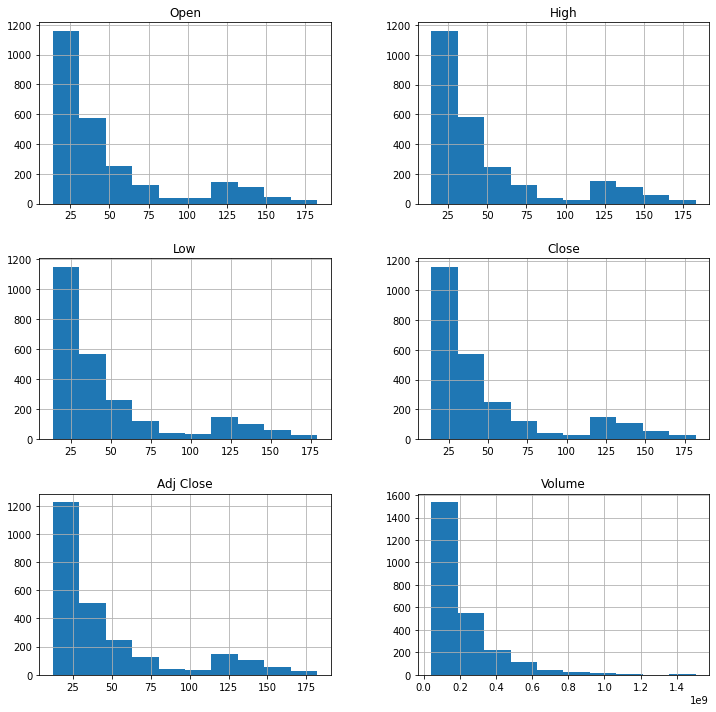

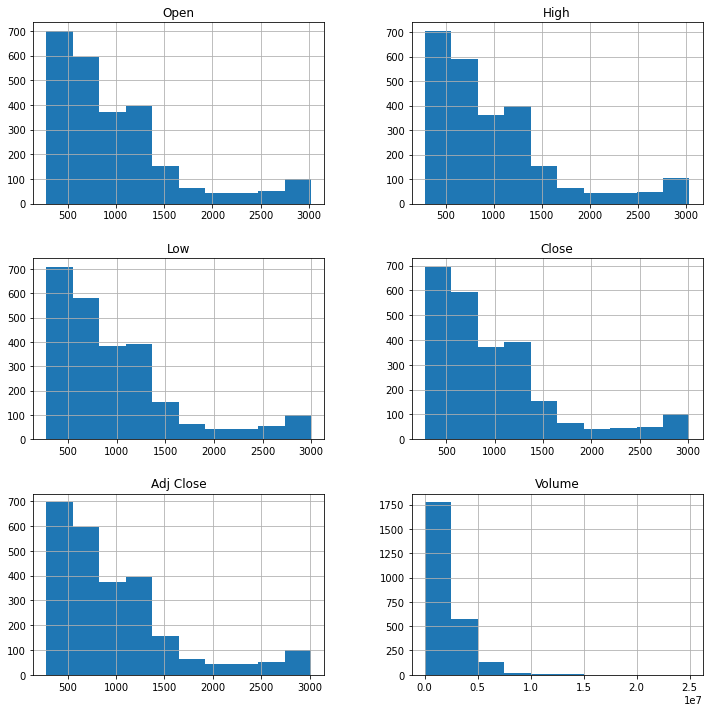

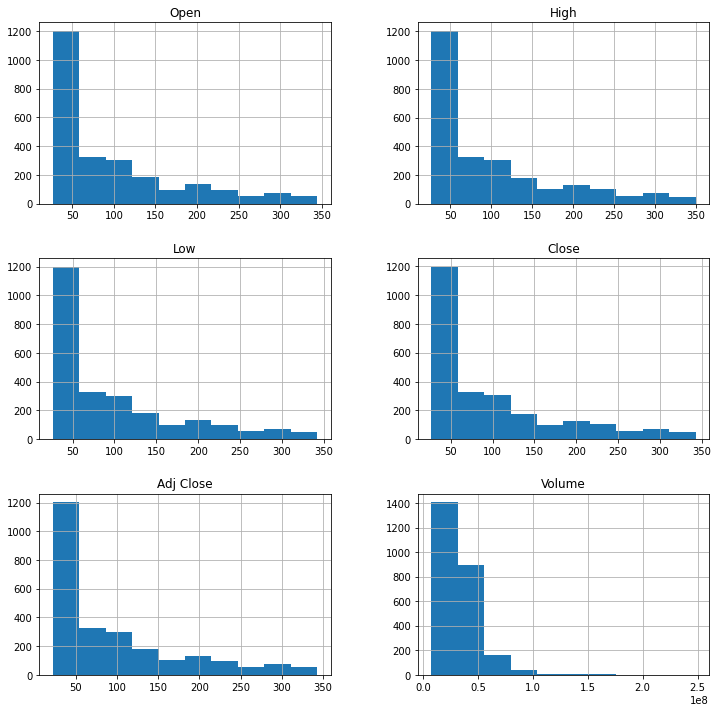

In [9]:
df.groupby("company_name").hist(figsize=(12, 12))

# 2. Moving average를 통해 데이터의 변화 양상을 확인해봅시다.

In [10]:
ma_day = [10, 20, 50, 200] # 10일치, 20일치, 50일치의 moving average를 통해 변화양상을 확인해봅시다.

# sliding window가 10, 20, 50 인 것으로 생각
for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()  # .rolling(ma)써서 기간 평균값 새로 추가하기 - MA for [10/20/50] 추가됐음

In [11]:
print(GOOG.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days',
       'MA for 200 days'],
      dtype='object')


- moving average에 사용되는 window의 크기가 클수록 더 긴 기간의 trend를 확인할 수 있고, window의 크기가 작을수록 짧은 구간의 trend 변화를 확인할 수 있습니다.

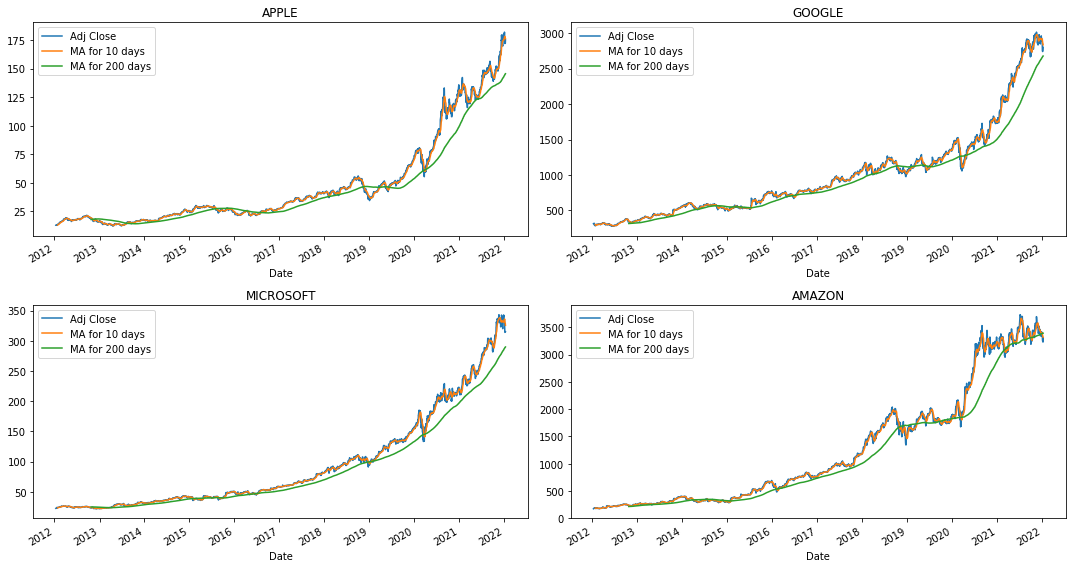

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

plot_columns = ['Adj Close', 'MA for 10 days', 'MA for 200 days']  # 'MA for 20 days', 'MA for 50 days']

AAPL[plot_columns].plot(ax=axes[0,0])   #.iloc[-500:].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[plot_columns].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[plot_columns].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[plot_columns].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

# 3. 수익률을 분석해봅시다.
- Pandas dataframe 은 pct_change 라는 수익률 분석 함수를 제공합니다. 이 함수는 아래의 값을 계산합니다.
    - (현재 값 - 직전 값)/직전 값
    - 종가에 적용하면 전날 종가대비 당일의 종가가 얼마나 상승했는지를 비율로 나타내게 됩니다.

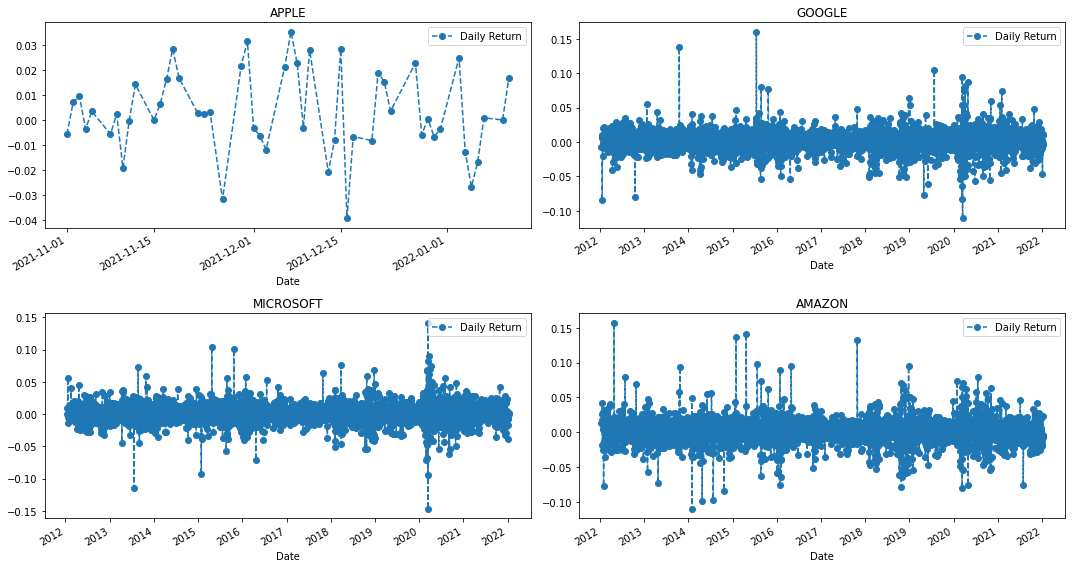

In [13]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2) # 2 * 2 subplot
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL['Daily Return'][-50:].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o') #이렇게 하면 최근 50일간의 데이터까지만 구해올 수 있음
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

- Histogram 을 이용해서도 분석해봅시다. (Seaborn 라이브러리 이용)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

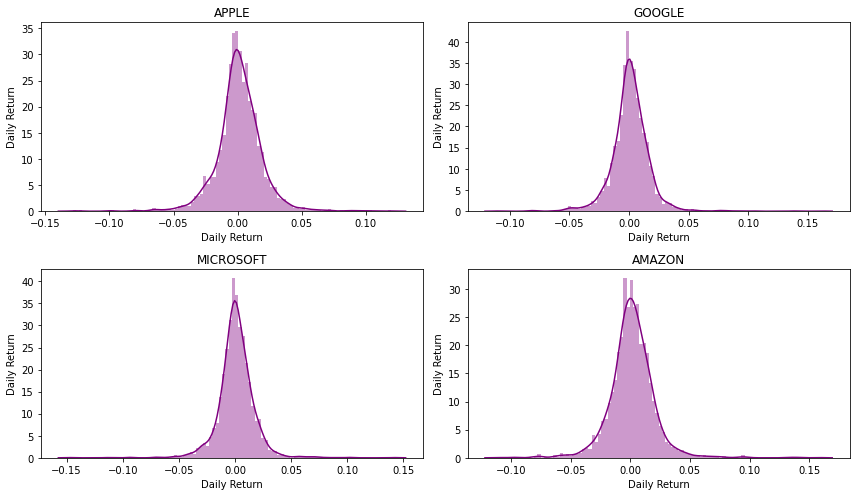

In [14]:
plt.figure(figsize=(12, 7))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    sns.distplot(company['Daily Return'].dropna(), bins=100, color='purple') # nan value는 seaborn 에서 읽을 수 없으므로 dropna 를 통해 처리하였습니다.
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')
plt.tight_layout()

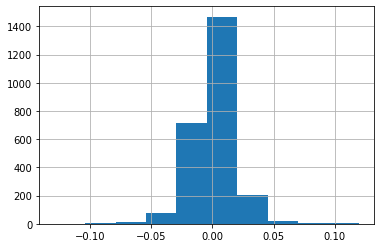

In [15]:
# pandas dataframe 에서 제공하는 histogram 함수를 사용해도 됩니다.
AAPL['Daily Return'].hist()


# 4. 서로 다른 주식의 종가들 간의 관계성을 분석해봅시다.

Now that we have all the closing prices, let's go ahead and get the daily return for all the stocks, like we did for the Apple stock.

In [16]:
closing_df = pd.DataFrame([AAPL['Adj Close'], GOOG['Adj Close'], MSFT['Adj Close'], AMZN['Adj Close']]).T
closing_df.columns = ['AAPL','GOOG','MSFT','AMZN']

In [17]:
# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()   # 2012-01-12가 NaN => 어떠한 이유때문인지 몰라도 NaN값 처리해줘야지 

,AAPL,GOOG,MSFT,AMZN
Date,,,,
2012-01-12,NaN,NaN,NaN,NaN
2012-01-13,-0.003750,-0.007385,0.008929,0.014153
2012-01-17,0.011648,0.005744,0.000354,0.018159
2012-01-18,0.010384,0.006889,-0.001061,0.042827
2012-01-19,-0.003169,0.010523,-0.003897,0.026446


- seaborn 라이브러리의 jointplot을 통해 관계성을 분석해봅시다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


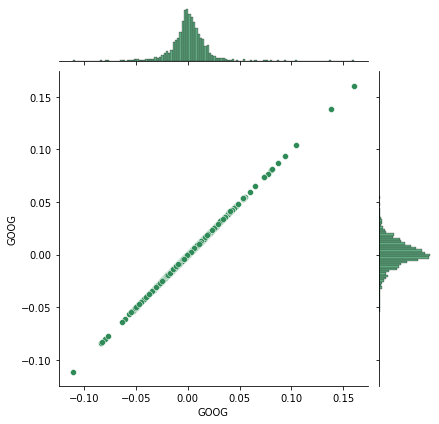

In [18]:
# 자기 자신과의 비교를 먼저 진행해봅시다. 자기 자신과 비교하면 correlation이 아주 강하게 나타나는 것을 볼 수 있습니다. (correlation = 1.0, 정비례)
sns.jointplot('GOOG', 'GOOG', tech_rets, kind='scatter', color='seagreen')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/pyth

'\n결과를 통해 아래의 질문에 답을 해보세요.\n1. correlation이 높은가요? 아니면 낮은가요?\n2. 그렇다면 Google 주식을 feature로 사용하면 Microsoft 주식을 예측할 때 도움이 될까요?\n'

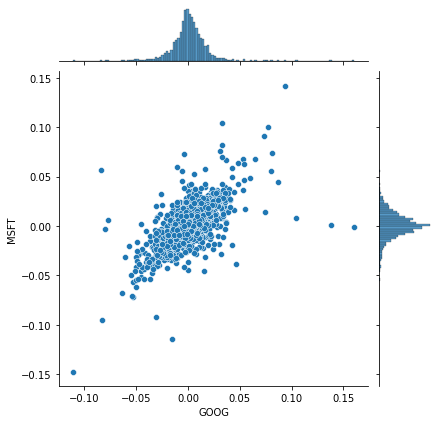

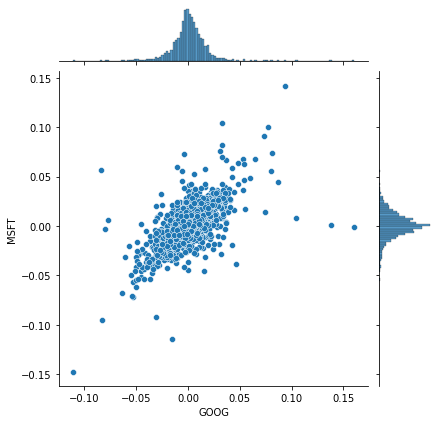

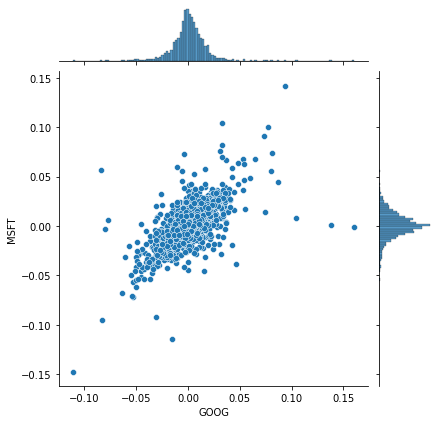

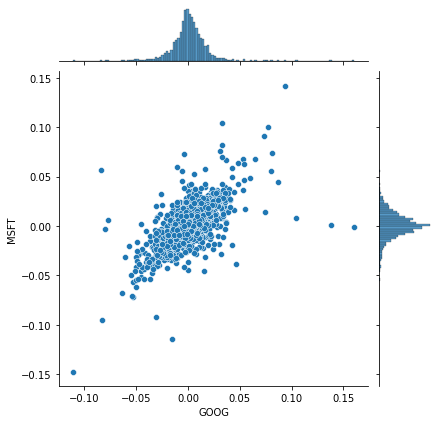

In [19]:
# Google 과 Microsoft를 비교해봅시다.
sns.jointplot('GOOG', 'MSFT', tech_rets, kind='scatter')
sns.jointplot('GOOG', 'MSFT', tech_rets, kind='scatter')
sns.jointplot('GOOG', 'MSFT', tech_rets, kind='scatter')
sns.jointplot('GOOG', 'MSFT', tech_rets, kind='scatter')

"""
결과를 통해 아래의 질문에 답을 해보세요.
1. correlation이 높은가요? 아니면 낮은가요?
2. 그렇다면 Google 주식을 feature로 사용하면 Microsoft 주식을 예측할 때 도움이 될까요?
"""

- Pandas와 seaborn을 혼합하면 이러한 분석을 모든 pair에 대해 아주 쉽게 적용할 수 있습니다.

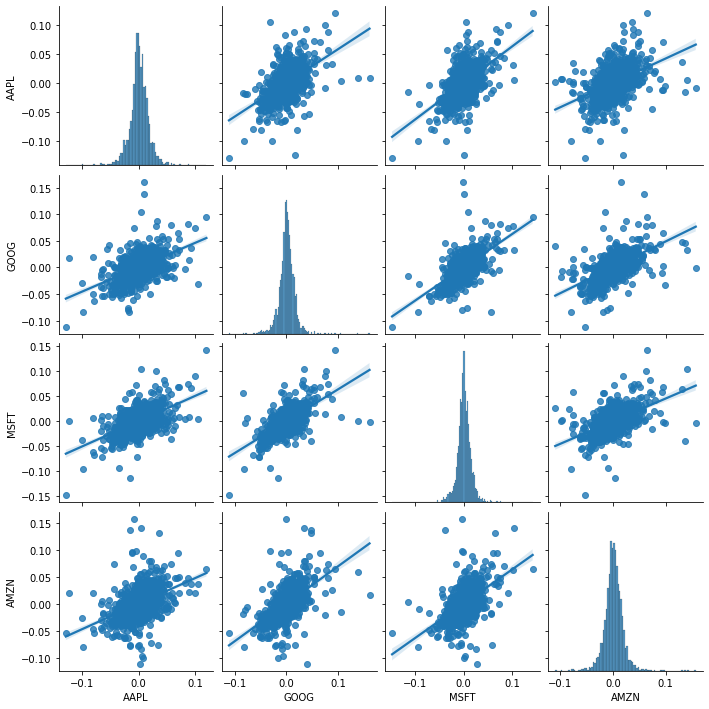

In [20]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

- Seaborn 의 pairplot은 pairgrid 함수를 통해 좀 더 다양한 버전으로 적용될 수 있습니다. 이를 통해 다양한 방식으로 데이터를 분석하는 것이 가능합니다.
    - 여기서는 이를 통해 분석을 진행하기보다는, 사용하는 방법에 대해서만 확인하고 넘어가도록 하겠습니다.
    - 이 예제에서는 위쪽 삼각형에서는 scatter plot, 아래쪽 삼각형에서는 kernel density estimation plot, 대각에는 histogram을 그려보겠습니다.

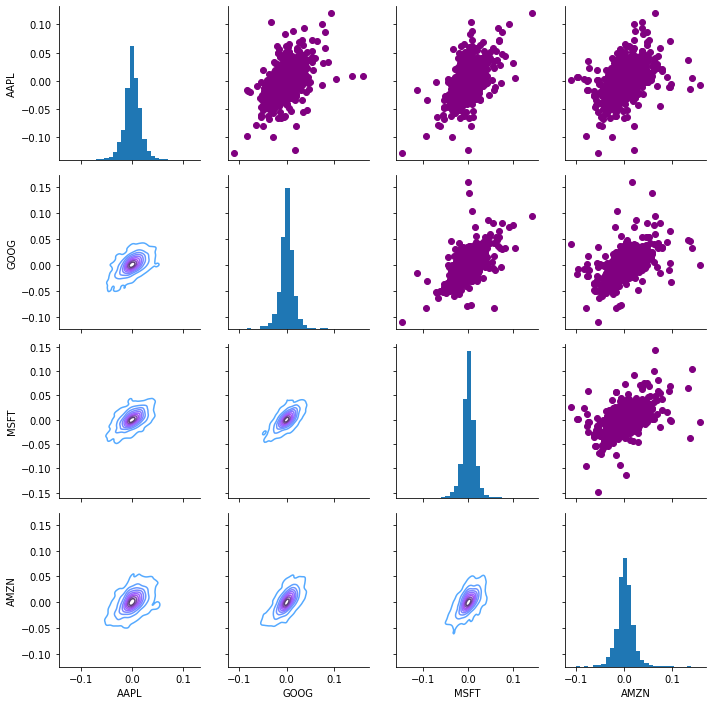

In [21]:
# 우선, 수익률을 통해 분석해봅시다.
return_fig = sns.PairGrid(tech_rets.dropna())

return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d') # kde 에서 회색 선은 등고선을 의미합니다
return_fig.map_diag(plt.hist, bins=30)

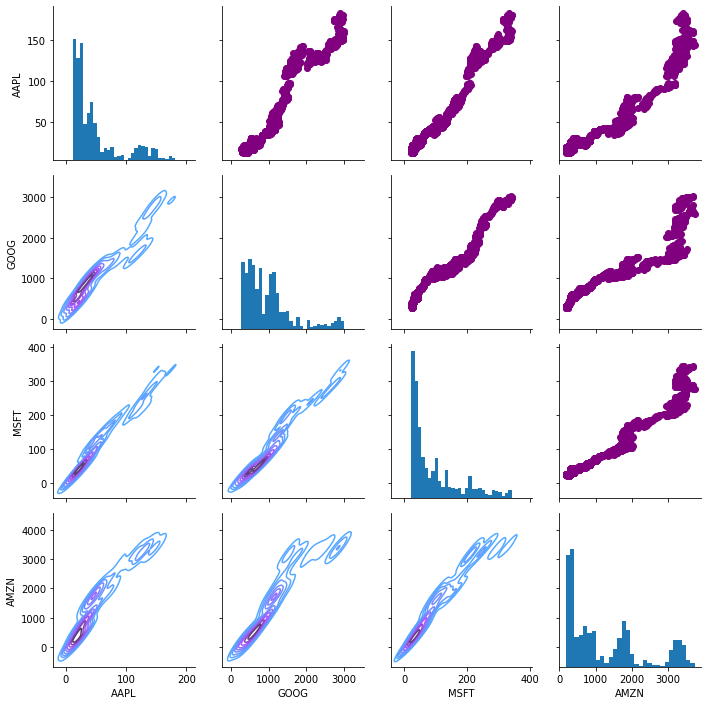

In [22]:
# 종가 데이터를 통해 분석해봅시다.
returns_fig = sns.PairGrid(closing_df)

returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')
returns_fig.map_diag(plt.hist,bins=30)

- pandas 의 corr 함수를 통해 pearson correlation을 간단히 계산할 수도 있습니다.

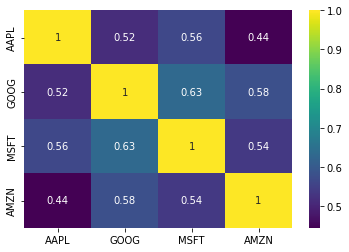

In [23]:
sns.heatmap(tech_rets.corr(), annot=True, cmap='viridis')

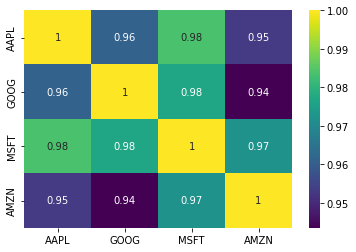

In [24]:
sns.heatmap(closing_df.corr(), annot=True, cmap='viridis')

# 5. Apple, Google, Microsoft, Amazon의 주식 종가를 예측해봅시다.

In [25]:
df = closing_df

In [26]:
df.columns

Index(['AAPL', 'GOOG', 'MSFT', 'AMZN'], dtype='object')

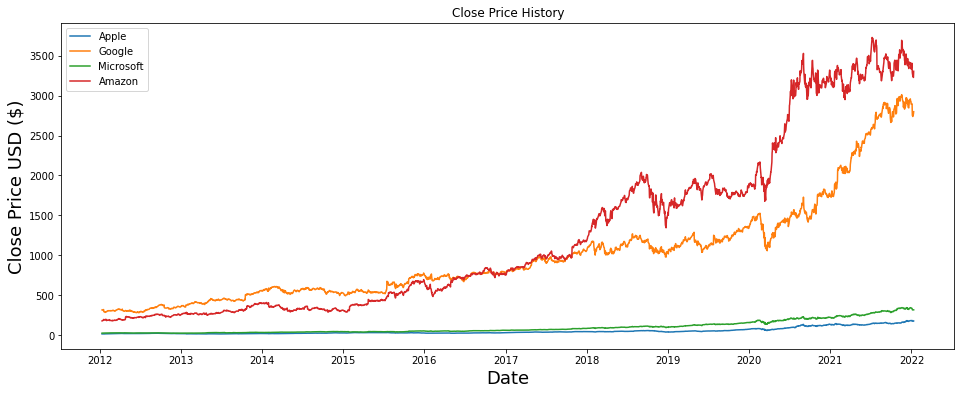

In [27]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['AAPL'], label='Apple')
plt.plot(df['GOOG'], label='Google')
plt.plot(df['MSFT'], label='Microsoft')
plt.plot(df['AMZN'], label='Amazon')
plt.legend(loc='upper left')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# 5-1. 데이터 전처리 

In [28]:
# data split 
train_data_length = int(len(df) * 0.8)
val_data_length = int(len(df) * 0.1)

train_df = df.iloc[:train_data_length]   #8년은 train
val_df = df.iloc[train_data_length:train_data_length+val_data_length] #8년 이후 1년은 validation
test_df = df.iloc[train_data_length+val_data_length:]   #나머지 1년은 test   #shuffle안하고 앞에서 잘라야해

In [29]:
train_df.shape, val_df.shape, test_df.shape

((2013, 4), (251, 4), (253, 4))

# 5-2. Dataset class 만들기, Dataloader 만들기

In [30]:
class StandardScaler():
    def __init__(self):
        self.mean = None
        self.stdev = None
        
    def fit(self, x, dim=None):
        if not torch.is_tensor(x): # numpy array -> torch tensor 
            x = torch.tensor(x)# We can simply call pairplot on our DataFrame for an automatic visual analysis 

        
        if dim is not None:
            self.mean = x.mean(dim) # x.shape = (batch=8, )
            self.stdev = x.std(dim)
        else:
            self.mean = x.mean()
            self.stdev = x.std()
        
    def scale(self, x):# We can simply call pairplot on our DataFrame for an automatic visual analysis 

        if not torch.is_tensor(x): # numpy array -> torch tensor 
            x = torch.tensor(x)
        return (x - self.mean.to(x.device)) / self.stdev.to(x.device)  # 둘다 gpu에 있든, cpu에 있든 똑같은 곳에 있어야 연산이 된다. 
    
    def unscale(self, x):
        if not torch.is_tensor(x): # numpy array -> torch tensor 
            x = torch.tensor(x)
        return x * self.stdev.to(x.device) + self.mean.to(x.device) # 역 연산으로 원래 scale로 돌아가게 한다.
# We can simply call pairplot on our DataFrame for an automatic visual analysis 

class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, data, backcast_length, forecast_length, scaler=None):
        self.data_columns = data.columns
        self.data = data.values
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        
        if scaler is None:
            # train
            self.scaler = StandardScaler()
            self.scaler.fit(self.data, dim=0)
        else:
            self.scaler = scaler
        self.data = self.scaler.scale(self.data)
        

    def __len__(self):
        return len(self.data) - self.backcast_length - self.forecast_length + 1     #sliding window때문에. 그 size를 유지해 주는 것

    def __getitem__(self, idx):
        x_end = idx + self.backcast_length
        y_end = x_end + self.forecast_length

        x = self.data[idx:x_end]
        y = self.data[x_end:y_end]
        
        x = x.float()
        y = y.float()
        
        return x, y 
    
    def unscale(self, x):
        return self.scaler.unscale(x)

In [31]:
batch_size = 128
num_workers = 2
pin_memory = True

backcast_length = 30
forecast_length = 30

In [32]:
train_dataset = TimeseriesDataset(train_df, backcast_length, forecast_length, scaler=None)
val_dataset = TimeseriesDataset(val_df, backcast_length, forecast_length, scaler=train_dataset.scaler)
test_dataset = TimeseriesDataset(test_df, backcast_length, forecast_length, scaler=train_dataset.scaler)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                               num_workers=num_workers, pin_memory=pin_memory)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                               num_workers=num_workers, pin_memory=pin_memory)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                               num_workers=num_workers, pin_memory=pin_memory)

# 5-3. 모델 정의하기 

In [33]:
class RNNmodel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, LSTM=False, GRU=False, num_layers=4, bidirectional=False, dropout=0.3, batch_first=True, backcast_length=30, forecast_length=30):
        super(RNNmodel, self).__init__()
        # hidden_dim : 키우면 모델도 커짐. LSTM, GRU둘중 하나만 True여야 함. bidirectional은 앞으로도 영향을 줄 수 있기 때문에 만들어준 값. generalize잘하게끔 dropout(무작위로 없애기) time_series에서는 batch_first는 항상!
        self.LSTM = LSTM # LSTM인지 아닌지 여부를 저장해둡니다.
        self.n_direction = 2 if bidirectional else 1
        self.backcast_length = backcast_length 
        self.forecast_length = forecast_length
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        
        if LSTM:
            rnn = nn.LSTM
        elif GRU: 
            rnn = nn.GRU
        else:
            rnn = nn.RNN
            
            
        self.rnn = rnn(input_size = feature_dim, 
                       hidden_size = hidden_dim, 
                       num_layers = num_layers,
                       bias = True,
                       batch_first = batch_first,
                       dropout = dropout,
                       bidirectional = bidirectional)# We can simply call pairplot on our DataFrame for an automatic visual analysis 

        self.out = nn.Linear(hidden_dim * self.n_direction, feature_dim)  # bidrection이면 2배가 됨. 
        
    def forward(self, x):
        # x: (batch, sequence length, feature_dim)
        
        
        # many to many 구조를 구현해봅시다.
        
        if self.LSTM:
            h0 = (torch.zeros(self.num_layers * self.n_direction, x.shape[0], self.hidden_dim, device=x.device),
                  torch.zeros(self.num_layers * self.n_direction, x.shape[0], self.hidden_dim, device=x.device))
        else:
            h0 = torch.zeros(self.num_layers * self.n_direction, x.shape[0], self.hidden_dim, device=x.device)
        
        x, h = self.rnn(x, h0)
        outs = []
        for i in range(self.forecast_length):
            x = self.out(x[:,-1:,:])
            outs.append(x.squeeze(1))
            
            if i == self.forecast_length-1:
                break
                
            x, h = self.rnn(x, h) # x, h 를 받아서 다시 x, h를 리턴한다. rnn에서 나온 vector가 hidden을 거쳐서 output 생성, 또 다른 input으로 바꾼다. outs=[]에 모아놓기.
            
        outs = torch.stack(outs, dim=1) # batch, forecatst_length, feature_dim
        return outs

In [34]:
feature_dim=4
hidden_dim=64

model = RNNmodel(feature_dim, hidden_dim, LSTM=False, GRU=True)

# 5-4. 학습 방식 정의하기

In [35]:
learning_rate = 1e-4

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 5-5. 학습 진행하기

In [36]:
num_epoch = 100



import time
train_losses = []
val_losses = []
best_epoch = 0
start_time = time.time()
best_model_state_dict = None
best_val_loss = 10000   # 매우 큰 수로 놓고, loss는 이것보다 작아질 것이기 때문에.

for epoch in range(num_epoch):
    train_loss_mean = 0
    val_loss_mean = 0
    
    # train
    model.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
#         inputs = inputs.cuda()
#         labels = labels.cuda()
        
        forecast = model(inputs)
    
        forecast = model(inputs)
        loss = criterion(forecast.sum(0), labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_mean += loss.item()
        
        if i % 100 == 0:
            print('epoch [{}/{}] iter [{:03d}/{:03d}] loss [{:.4f}] elapsed time [{:.2f}min]'.format(epoch, num_epoch, i, len(train_dataloader), loss.item(), (time.time()-start_time)/60))
    
    train_loss_mean = train_loss_mean/len(train_dataloader)
    
    train_losses.append(train_loss_mean)
    
    # validation
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
#             inputs = inputs.cuda()
#             labels = labels.cuda()

            forecast = model(inputs)
            loss = criterion(forecast.sum(0), labels)
            val_loss_mean += loss.item()

        val_loss_mean = val_loss_mean/len(val_dataloader)

        print('epoch [{}/{}] train loss [{:.4f}] validation loss [{:.4f}] elapsed time [{:.2f} min]\n'.format(epoch, num_epoch, train_loss_mean, val_loss_mean, (time.time()-start_time)/60))

        if val_loss_mean < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss_mean
            best_model_state_dict = model.state_dict()
    val_losses.append(val_loss_mean)# We can simply call pairplot on our DataFrame for an automatic visual analysis 


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([128, 30, 4])) that is different to the input size (torch.Size([30, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch [0/100] iter [000/016] loss [9.5993] elapsed time [0.15min]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([34, 30, 4])) that is different to the input size (torch.Size([30, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch [0/100] train loss [5.7153] validation loss [5.3207] elapsed time [0.23 min]



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([64, 30, 4])) that is different to the input size (torch.Size([30, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


epoch [1/100] iter [000/016] loss [3.2919] elapsed time [0.24min]
epoch [1/100] train loss [1.8497] validation loss [3.6898] elapsed time [0.33 min]

epoch [2/100] iter [000/016] loss [1.1168] elapsed time [0.34min]
epoch [2/100] train loss [1.0314] validation loss [4.2812] elapsed time [0.43 min]

epoch [3/100] iter [000/016] loss [0.8590] elapsed time [0.44min]
epoch [3/100] train loss [0.8600] validation loss [4.2187] elapsed time [0.53 min]

epoch [4/100] iter [000/016] loss [0.7972] elapsed time [0.54min]
epoch [4/100] train loss [0.8234] validation loss [4.1598] elapsed time [0.63 min]

epoch [5/100] iter [000/016] loss [0.7797] elapsed time [0.64min]
epoch [5/100] train loss [0.8122] validation loss [4.2121] elapsed time [0.72 min]

epoch [6/100] iter [000/016] loss [0.8008] elapsed time [0.73min]
epoch [6/100] train loss [0.8089] validation loss [4.2382] elapsed time [0.83 min]

epoch [7/100] iter [000/016] loss [0.7970] elapsed time [0.84min]
epoch [7/100] train loss [0.8115] 

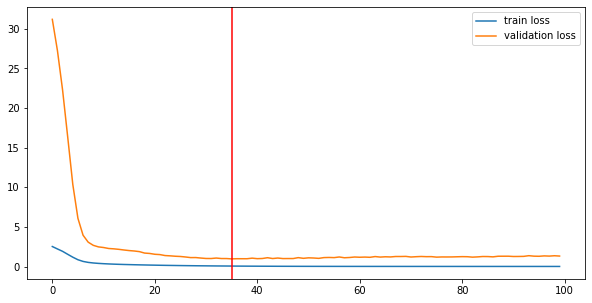

In [76]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.axvline(best_epoch, color='red') # early stopping 
plt.legend()
plt.show()

# validation data 에 대한 실제 값과 예측 값을 확인해봅시다.

In [77]:
# validation 결과를 저장해서 그려봅시다.
predictions = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_dataloader):
        forecast = model(inputs)
        predictions.append(forecast.data.cpu())
predictions = torch.cat(predictions, dim=0)

RuntimeError: ignored

In [78]:
predictions.shape

AttributeError: ignored

In [ ]:
def plot_prediction_after_N_days(real,pred,N=5):
    #
    pred = pred[:,N,:]
    real = real.iloc[N:]
    real = real.iloc[:len(pred)]
    
    cmap=['red','orange','skyblue','green']
    plt.figure(figsize=(16,5))
    for i, col in enumerate(real.columns):
        plt.plot(real[col], label=col+' Real', c=cmap[i], linestyle='--')
    
    pred_df = pd.DataFrame(pred.data.cpu().numpy())
    pred_df.index = real.index
    pred_df.columns = real.columns
    for i, col in enumerate(real.columns):
        plt.plot(pred_df[col], label=col+' Pred', c=cmap[i])
    plt.legend()
    plt.show()

In [ ]:
validation_real = val_df.iloc[backcast_length:]  # 입력으로만 사용된 데이터는 제외하였습니다.
plot_prediction_after_N_days(validation_real, train_dataset.scaler.unscale(predictions), N=1) # N=5 이면 5일 뒤를 예측한 결과를 plot합니다.

# Test 데이터에도 적용해봅시다.

In [79]:
predictions = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        forecast = model(inputs)
        predictions.append(forecast.data.cpu())
predictions = torch.cat(predictions, dim=0)

RuntimeError: ignored

In [80]:
test_real = test_df.iloc[backcast_length:]  # 입력으로만 사용된 데이터는 제외하였습니다.
plot_prediction_after_N_days(test_real, train_dataset.scaler.unscale(predictions), N=3)

RuntimeError: ignored

# 6. N-BEATS 모델을 사용해봅시다.

In [81]:
class NBeatsNet(nn.Module):
    def __init__(self,
                 forecast_length=24,
                 backcast_length=96,
                 theta_dim=(2, 8, 3), # 2차식으로 표현하겠다. trend, seasonal ,residual 
                 n_trend=3,  # stack 하나에 trend block이 몇개 들어있는지
                 n_seasonality=3,
                 n_residual=3,
                 hidden_dim=512,
                 feature_dim=4):
        super(NBeatsNet, self).__init__()        
            
        self.trend_stack = []
        self.seasonality_stack = []
        self.residual_stack = [] #bs =[] 이건했는데 fs=[] 이거 안해줌
        # We can simply call pairplot on our DataFrame for an automatic visual analysis 

        for i in range(n_trend):
            self.trend_stack.append(Block(backcast_length, forecast_length, hidden_dim, theta_dim[0], mode='trend', feature_dim=feature_dim))    

        for i in range(n_seasonality):
            self.seasonality_stack.append(Block(backcast_length, forecast_length, hidden_dim, theta_dim[1], mode='seasonality', feature_dim=feature_dim))
        
        for i in range(n_residual):
            self.residual_stack.append(Block(backcast_length, forecast_length, hidden_dim, theta_dim[2], mode='residual', feature_dim=feature_dim))
        # We can simply call pairplot on our DataFrame for an automatic visual analysis 

        
        self.trend_stack = nn.ModuleList(self.trend_stack)
        self.seasonality_stack = nn.ModuleList(self.seasonality_stack)
        self.residual_stack = nn.ModuleList(self.residual_stack)

    def forward(self, backcast):# We can simply call pairplot on our DataFrame for an automatic visual analysis 
# We can simply call pairplot on our DataFrame for an automatic visual analysis 

        backcast_stack = []
        forecast_stack = []

        for layer in self.trend_stack:
            b, f = layer(backcast)
            backcast_stack.append(b)
            forecast_stack.append(f)
            backcast = backcast - b  # 현재 예측한 backcast만큼 빼줘야지

        for layer in self.seasonality_stack:
            b, f = layer(backcast)
            backcast_stack.append(b)
            forecast_stack.append(f)
            backcast = backcast - b


        for layer in self.residual_stack:
            b, f = layer(backcast)
            backcast_stack.append(b)
            forecast_stack.append(f)
            backcast = backcast - b

        backcast = torch.stack(backcast_stack, 0)  #[trend_b1, trend_b2,trend_b3, sea_b1, sea_b2,,,,,res_b3] block들이 들어가있음
        forecast = torch.stack(forecast_stack, 0)
        return backcast, forecast


# ours
class Block(nn.Module): # Block input 만들기
    def __init__(self, backcast_length, forecast_length, hidden_dim, theta_dim, mode, feature_dim):
        super(Block, self).__init__()
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.theta_dim = theta_dim
        self.mode = mode

        self.MLP = nn.Sequential(
                nn.Linear(backcast_length * feature_dim, hidden_dim), 
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU() # fully connected stack의 부분.
            ) # univariate??multivariate??

        if mode == 'residual':
            # residual  
            self.theta_b = nn.Linear(hidden_dim, theta_dim * feature_dim) # hidden: 입력 dimension, 뒷부분은 입,출력이 같아야한다. theta_dim만큼 출력한다.       
            self.theta_f = nn.Linear(hidden_dim, theta_dim * feature_dim) 
            self.linear_b = nn.Linear(theta_dim, backcast_length)
            self.linear_f = nn.Linear(theta_dim, forecast_length)
        else:
            # trend, seasonality# We can simply call pairplot on our DataFrame for an automatic visual analysis 

            self.theta = nn.Linear(hidden_dim, theta_dim*feature_dim)


    def forward(self, x):
        shape = x.shape
        # x: (batch size, backcast length, feature_dim)
        t_b = ((torch.arange(start=0, end=self.backcast_length, device=x.device, dtype=torch.float) - self.backcast_length) / 24 ) # (backcast_len,)
        t_f = ((torch.arange(start=0, end=self.forecast_length, device=x.device, dtype=torch.float)) / 24 ) # (forecast_len,)

        # x -> h
        x = self.MLP(x.reshape(x.shape[0], -1)) # (batch, backcast length * feature_dim) -> (batch, theta_dim)
# We can simply call pairplot on our DataFrame for an automatic visual analysis 

        # h -> theta -> backcast, forecast
        if self.mode == 'residual':# We can simply call pairplot on our DataFrame for an automatic visual analysis 

            # residual block
            theta_b = self.theta_b(x).reshape(shape[0], shape[2], self.theta_dim)
            theta_f = self.theta_f(x).reshape(shape[0], shape[2], self.theta_dim)
            b = self.linear_b(theta_b).permute(0,2,1) # (batch, backcast length, feature_dim)  # 재배치 해주는 함수 
            f = self.linear_f(theta_f).permute(0,2,1) # (batch, forecast length, feature_dim)
        else:
            theta_b = self.theta(x).reshape(shape[0], self.theta_dim, shape[2])
            theta_f = theta_b  #같은 예측값을 사용하기로 했기 때문에. 

            # trend와 seasonality 나눠주기
            if self.mode == 'trend':  
                b = self.get_trend(theta_b, t_b) #theta_b와 theta_f를 같게 가져왔기 때문에 t_b, t_f에 따라서 forecast인지 backcast인지 구분한다. 
                f = self.get_trend(theta_f, t_f)
                
            elif self.mode == 'seasonality':
                b = self.get_seasonality(theta_b, t_b)
                f = self.get_seasonality(theta_f, t_f)
        return b, f# We can simply call pairplot on our DataFrame for an automatic visual analysis 


    def get_trend(self, theta, t):
        # theta dim = 0 -> 수평선 (y=a)
        # theta dim = 1 -> 직선 (y=bx)
        # theta dim = 2 -> 이차곡선 (y=cx^2)
        # ...

        T = torch.stack([t ** i for i in range(theta.shape[1])])  # (theta_dim ,sequence length)
        out = torch.einsum('btf,ts->bsf', theta, T) # theta, T를 입력받음

        return out


    def get_seasonality(self, theta, t):
        s1 = torch.stack([torch.cos(2 * np.pi * (i+1) * t) for i in range(self.theta_dim//2)]).float()  # H/2-1
        s2 = torch.stack([torch.sin(2 * np.pi * (i+1) * t) for i in range(self.theta_dim//2)]).float()
        S = torch.cat([s1, s2])# We can simply call pairplot on our DataFrame for an automatic visual analysis 

        out = torch.einsum('btf,ts->bsf', theta, S) 
        return out

In [82]:
# model hyper parameters
theta_dim=(2, 8, 3) # theta_dim=2 이면 2차곡선, sin_term 4개, cos_term 4개가 반복된다. 
n_trend=3
n_seasonality=3
n_residual=3
hidden_dim=64


model = NBeatsNet(forecast_length, backcast_length, theta_dim, n_trend, n_seasonality, n_residual, hidden_dim)
model = model.cuda()

# We can simply call pairplot on our DataFrame for an automatic visual analysis 


In [83]:
learning_rate = 1e-4

criterion = nn.MSELoss() #nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [84]:
num_epoch = 100



import time
train_losses = []
val_losses = []
best_epoch = 0
start_time = time.time()
best_model_state_dict = None
best_val_loss = 10000
for epoch in range(num_epoch):
    train_loss_mean = 0
    val_loss_mean = 0
    
    # train
    model.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        forecast = model(inputs)
    
        backcast, forecast = model(inputs)
        loss = criterion(backcast.sum(0), inputs) + criterion(forecast.sum(0), labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_mean += loss.item()
        
        if i % 100 == 0:# We can simply call pairplot on our DataFrame for an automatic visual analysis 

            print('epoch [{}/{}] iter [{:03d}/{:03d}] loss [{:.4f}] elapsed time [{:.2f}min]'.format(epoch, num_epoch, i, len(train_dataloader), loss.item(), (time.time()-start_time)/60))
    
    train_loss_mean = train_loss_mean/len(train_dataloader)
    
    train_losses.append(train_loss_mean)
    
    # validation
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.cuda()
            labels = labels.cuda()

            backcast, forecast = model(inputs)
            loss = criterion(backcast.sum(0), inputs) + criterion(forecast.sum(0), labels)
            val_loss_mean += loss.item()

        val_loss_mean = val_loss_mean/len(val_dataloader)

        print('epoch [{}/{}] train loss [{:.4f}] validation loss [{:.4f}] elapsed time [{:.2f} min]\n'.format(epoch, num_epoch, train_loss_mean, val_loss_mean, (time.time()-start_time)/60))

        if val_loss_mean < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss_mean
            best_model_state_dict = model.state_dict()
    val_losses.append(val_loss_mean)

epoch [0/100] iter [000/016] loss [2.7344] elapsed time [0.00min]
epoch [0/100] train loss [2.6278] validation loss [29.7822] elapsed time [0.02 min]

epoch [1/100] iter [000/016] loss [2.4479] elapsed time [0.03min]
epoch [1/100] train loss [2.3265] validation loss [26.6746] elapsed time [0.04 min]

epoch [2/100] iter [000/016] loss [2.3607] elapsed time [0.05min]
epoch [2/100] train loss [2.0041] validation loss [22.2964] elapsed time [0.07 min]

epoch [3/100] iter [000/016] loss [1.7750] elapsed time [0.07min]
epoch [3/100] train loss [1.6389] validation loss [16.5554] elapsed time [0.09 min]

epoch [4/100] iter [000/016] loss [1.4151] elapsed time [0.09min]
epoch [4/100] train loss [1.2263] validation loss [10.6042] elapsed time [0.11 min]

epoch [5/100] iter [000/016] loss [1.0770] elapsed time [0.11min]
epoch [5/100] train loss [0.8863] validation loss [5.9555] elapsed time [0.13 min]

epoch [6/100] iter [000/016] loss [0.7422] elapsed time [0.13min]
epoch [6/100] train loss [0.6

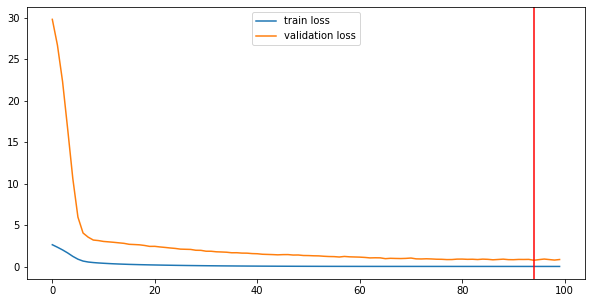

In [85]:
 plt.figure(figsize=(10,5))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.axvline(best_epoch, color='red') # early stopping best에서 멈추기 
plt.legend()
plt.show()

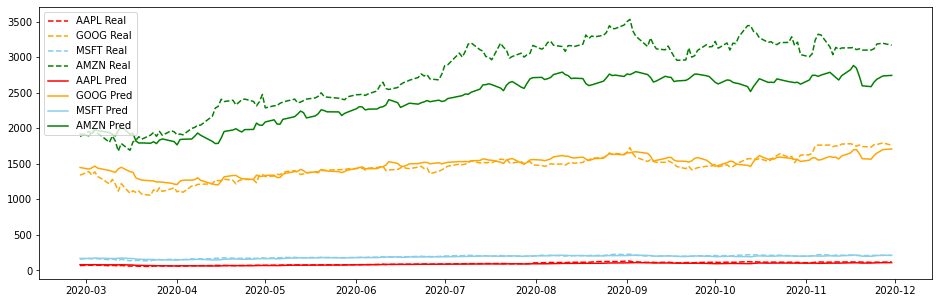

In [86]:
# validation 결과를 저장해서 그려봅시다.
predictions = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_dataloader):
        inputs = inputs.cuda()
        backcast, forecast = model(inputs)
        predictions.append(forecast.sum(0).data.cpu())
predictions = torch.cat(predictions, dim=0)

validation_real = val_df.iloc[backcast_length:]  # 입력으로만 사용된 데이터는 제외하였습니다.
plot_prediction_after_N_days(validation_real, train_dataset.scaler.unscale(predictions), N=1) # N=5 이면 5일 뒤를 예측한 결과를 plot합니다.

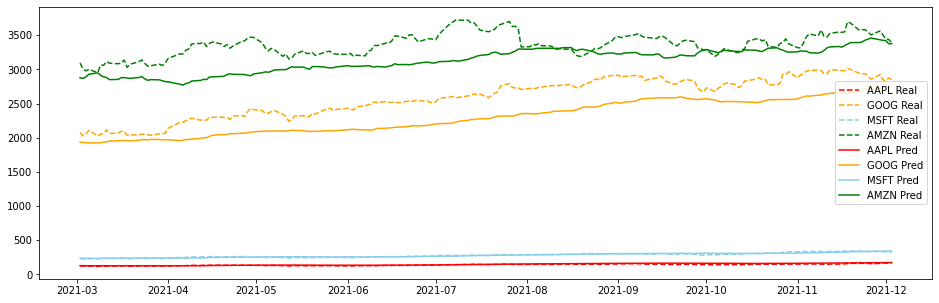

In [87]:
# test 결과를 저장해서 그려봅시다.
predictions = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.cuda()
        backcast, forecast = model(inputs)
        predictions.append(forecast.sum(0).data.cpu())
predictions = torch.cat(predictions, dim=0)

test_real = test_df.iloc[backcast_length:]  # 입력으로만 사용된 데이터는 제외하였습니다.
plot_prediction_after_N_days(test_real, train_dataset.scaler.unscale(predictions), N=3)# We can simply call pairplot on our DataFrame for an automatic visual analysis 


In [88]:
def MAE(x, y):
    return np.mean(np.abs(x-y))
  
def RMSE(x,y):
    return np.sqrt(np.mean((x-y))**2)

def metric(real, pred, N=5):
    pred = pred[:,N,:]
    real = real.iloc[N:]
    real = real.iloc[:len(pred)]

    pred = np.array(pred)
    real = np.array(real)

    mae = MAE(pred, real)
    rmse = RMSE(pred, real)

    return mae, rmse

In [89]:
mae, rmse = metric(test_real, train_dataset.scaler.unscale(predictions), N=5) # 5일뒤 예측결과

print('MAE: {:.3f}'.format(mae))
print('RMSE: {:.3f}'.format(rmse))

MAE: 160.449
RMSE: 153.438
